In [2]:
import numpy as np
import pandas as pd
import time
import sys
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
X = np.load('XX.npy').reshape((-1,18,20))
Y = np.load('YY.npy').reshape((-1,18))
print(f'input shape: {X.shape}, output shape {Y.shape}') # 18 transmitter * 1702 receiver = 127836 samples which is flatten for this task

input shape: (7102, 18, 20), output shape (7102, 18)


In [4]:
#@title Scikit-learn libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.decomposition import KernelPCA, PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, LearningCurveDisplay, ShuffleSplit, RandomizedSearchCV, learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, f1_score, average_precision_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# EL class object for random classifier selection and prediction


In [5]:
class ELClass:
  def __init__(self, X, Y):
#    self.num_batch = num_batch
#    self.batch_size = X.shape[0] // self.num_batch


    self.test_size = 0.2
    self.X = X
    self.Y = Y #labels.reshape((labels[0],-1))

    self.predicators = []

    self.scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='macro'),
    'auc': make_scorer(roc_auc_score, average='macro')
    }
    #self.multi_metrics = ['accuracy','f1','auc']
    #self.scoring = {'Accuracy': 'accuracy', "AUC": "roc_auc", 'f1': 'f1'}
    self.n_splits = 5
    self.stratified_kf = StratifiedKFold(n_splits=self.n_splits, shuffle=True)#, random_state=36)


  def train_test_split(self, x, y):
  #  X = np.transpose(self.FE, [1,0,2])
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=self.test_size, stratify=y) #random_state=1234,
    return  X_train, X_test, y_train, y_test

  def PipelineMaker(self):

    scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'Normalizer': Normalizer(),
      }

    transformers = {
    'PCA': PCA(n_components=None, random_state = 98),
    'KernelPCA': KernelPCA(n_components=None, random_state = 1),
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
    'TruncatedSVD': TruncatedSVD(random_state = 57)
      }

    estimators = {
#classic estimators
    'LogisticRegression': LogisticRegression(random_state=5256),
    'SVM': SVC(probability=True, random_state=589),
    'SGD': SGDClassifier(loss='modified_huber',random_state = 3489),
#    'KNN': KNeighborsClassifier(),
#    'NaiveBayes': GaussianNB(),
#boosting / homogeneous ensemble estimators
    'DecisionTree': DecisionTreeClassifier(random_state = 1234),
    'RandomForest': RandomForestClassifier(random_state=2331),
    'GradientBoosting': GradientBoostingClassifier(random_state=892),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=2971),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=35),
#Classic MLP, carried on on Scikit learn
    'MLP': MLPClassifier(random_state=1579, hidden_layer_sizes=(50,50,50), activation='relu', solver='adam', alpha=0.0001, max_iter=1000),
    #without this params for MLP the algorithm is not converged by using default params. these params will be tunned more in the next step
      }

    param_grids = {
        'scaler': list(scalers.values()),
        'transformer': list(transformers.values()),
        'estimator': list(estimators.values())
      }
#keys = list(scaler_dict.keys())
#random_key = random.choice(keys)

#    pipeline = Pipeline([
#    ('scaler', None),
#    ('transformer', None),
#    ('estimator', None)
#      ])
    scaler_key = random.choice(list(scalers.keys()))
    transformer_key = random.choice(list(transformers.keys()))
    estimator_key = random.choice(list(estimators.keys()))

    pipeline = Pipeline([
    ('scaler', scalers[scaler_key]),
    ('transformer', transformers[transformer_key]),
    ('estimator', estimators[estimator_key])
      ])

    return pipeline, param_grids

  def PipelineSelection(self):
    X_train, X_test, y_train, y_test = self.train_test_split(self.X, self.Y)

    meta_x = [] #np.zeros((self.num_batch,int(np.ceil(self.batch_size*0.1)),2))
    meta_y = [] #np.zeros((self.num_batch,int(np.ceil(self.batch_size*0.1))))
    acc_ave = []

        # Iterate over folds
    pipeline, param_grid = self.PipelineMaker()
    print(f'current estimator: {pipeline.steps[2][1]}')
    for fold, (train_index, val_index) in enumerate(self.stratified_kf.split(X_train, y_train)):
      if fold+1 == self.n_splits:
        print(f"Fold 1/5 to {fold + 1}/{self.n_splits} is predicted and sent to server")

      X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
      y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

      pipeline.fit(X_train_fold, y_train_fold)

      y_proba = pipeline.predict_proba(X_val_fold)
      if fold == 0: #It make the life easier since we can convert the final list to a np.array
        y_proba = np.delete(y_proba, np.random.randint(0, y_proba.shape[0]), axis=0)
        y_val_fold = np.delete(y_val_fold, np.random.randint(0, y_val_fold.shape[0]), axis=0)
        meta_x.append(y_proba)
      else:
        meta_x.append(y_proba)

      meta_y.append(y_val_fold)



    pipeline.fit(X_train, y_train)
    y_proba_f = pipeline.predict_proba(X_test)
    fpr, tpr, threshold = roc_curve(y_test, y_proba_f[:,1], drop_intermediate = False)
    optimal_threshold_index = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_threshold_index]
    y_pred = (y_proba[:, 1] >= optimal_threshold).astype(int)
    accuracy = accuracy_score(y_val_fold, y_pred)
    print('Accuracy: {}'.format(accuracy))

    return meta_x, meta_y

In [6]:
import tensorflow as tf

# Check if a GPU is available
if tf.test.gpu_device_name():
    print('GPU is available')
else:
    print('GPU is not available')


GPU is available


2024-07-08 20:35:35.383643: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-07-08 20:35:35.383664: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-07-08 20:35:35.383667: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-07-08 20:35:35.383693: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-08 20:35:35.383706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
bs_counts = 18
a = range(bs_counts)
XX_meta = []
YY_meta = []
with tf.device('/device:GPU:0'):
  for bs_id in a:
    print(f'TP = {bs_id}')
    EL = ELClass(X[:,bs_id,:], Y[:,bs_id])
    meta_x, meta_y = EL.PipelineSelection()
    XX_meta.append(meta_x)
    YY_meta.append(meta_y)

TP = 0
current estimator: SGDClassifier(loss='modified_huber', random_state=3489)
Fold 1/5 to 5/5 is predicted and sent to server
Accuracy: 0.06690140845070422
TP = 1
current estimator: AdaBoostClassifier(random_state=35)
Fold 1/5 to 5/5 is predicted and sent to server
Accuracy: 0.8626760563380281
TP = 2
current estimator: GradientBoostingClassifier(random_state=892)
Fold 1/5 to 5/5 is predicted and sent to server
Accuracy: 0.9383802816901409
TP = 3
current estimator: GradientBoostingClassifier(random_state=892)
Fold 1/5 to 5/5 is predicted and sent to server
Accuracy: 0.8609154929577465
TP = 4
current estimator: RandomForestClassifier(random_state=2331)
Fold 1/5 to 5/5 is predicted and sent to server
Accuracy: 0.14964788732394366
TP = 5
current estimator: ExtraTreesClassifier(random_state=2971)
Fold 1/5 to 5/5 is predicted and sent to server
Accuracy: 0.8257042253521126
TP = 6
current estimator: RandomForestClassifier(random_state=2331)
Fold 1/5 to 5/5 is predicted and sent to server


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.regularizers import l1, l2
from imblearn.under_sampling import RandomUnderSampler

In [14]:
class Integrator():
  def __init__(self, x, y, bs_counts):
#    super().__init__()

    self.x = np.array(x).reshape((-1,2))
    self.y = np.array(y).reshape((-1,))

    sampling_strategy = 'auto'
    random_state = 1234
    self.test_size = 0.1
    self.rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state)

    super(Integrator, self).__init__()
    self.bs_counts = bs_counts
    self.model = self.build_model()

  def UnderSampling(self):
    X_resampled, y_resampled = self.rus.fit_resample(self.x,self.y)
    padding_size = int(np.ceil(y_resampled.shape[0]/self.bs_counts))*self.bs_counts - y_resampled.shape[0]
    self.X_input = np.pad(X_resampled, ((0,padding_size),(0,0)), mode='constant').reshape((-1,bs_counts,2))
    self.y_input = np.pad(y_resampled, ((0,padding_size)), mode='constant').reshape((-1,bs_counts))
    print('X_input & y_input (undersampled): {} {}'.format(self.X_input.shape, self.y_input.shape))
    return self

  def train_test_split(self):
    self.X_train, self.X_test, y_train, y_test = train_test_split(self.X_input, self.y_input, test_size=self.test_size, shuffle = True)
    self.y_train, self.y_test = y_train.astype(np.float32), y_test.astype(np.float32)
    return self

  def dense_layer(self, units, regularizer):
    return tf.keras.layers.Dense(units=units, activation='relu', kernel_regularizer=regularizer, name = f'Dense{units}')

  def build_model(self):
    inputs = tf.keras.layers.Input((self.bs_counts,2), name='input')
    conv = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', name='conv1D')(inputs)
    maxpooling = tf.keras.layers.MaxPooling1D(pool_size=2, name = 'maxpooling')(conv)
    dense64 = self.dense_layer(units = 128, regularizer = tf.keras.regularizers.l1(0.01))(maxpooling)
    dense32 = self.dense_layer(units = 64, regularizer = tf.keras.regularizers.l2(0.01))(dense64) #tf.keras.layers.Dense(units, activation='relu')
    flatten = tf.keras.layers.Flatten()(dense32)
    outputs = self.dense_layer(units = self.bs_counts, regularizer = None)(flatten)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name = 'FL-Integrator')

  def compile(self, optimizer, loss, metrics):
    if metrics is None:
      self.metrics = {'binary_accuracy':tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
                 'precision':tf.keras.metrics.Precision(name='precision'),
                 'recall': tf.keras.metrics.Recall(name='recall'),
                 'auc':tf.keras.metrics.AUC(name='auc'),
                 'f1':tf.keras.metrics.F1Score(name='f1_score')}
    self.model.compile(optimizer=optimizer, loss=loss, metrics=self.metrics.values())

  def model_summary(self):
    optimizer = self.model.optimizer.get_config()['name'] if self.model.optimizer else None
    loss_func = self.model.loss
    metrics = self.metrics.keys()
    print("Optimizer:", optimizer)
    print("Loss function:", loss_func)
    print("Metrics:", metrics)
    self.model.summary()

  # def get_optimizer(self):
  #   return self.model.optimizer.get_config()['name'] if self.model.optimizer else None

  # def get_loss(self):
  #   return self.model.loss

  # def get_metrics(self):
  #   return self.metrics.keys()
  def fit(self, epochs, batch_size, verbose, callbacks, validation_split):
    self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size,
                                  verbose=verbose, callbacks=callbacks, validation_split = validation_split)

  def plot_history(self):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(self.history.history['binary_accuracy'])
    ax[0].plot(self.history.history['val_binary_accuracy'])
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')
    ax[0].grid(True, color='gray', linestyle='--', linewidth=0.5)

    # Plot training & validation loss values
    ax[1].plot(self.history.history['loss'])
    ax[1].plot(self.history.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')
    ax[1].grid(True, color='gray', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    return self

  def predict(self):
    self.predictions = self.model.predict(self.X_test)
    return self

  def confusion_matrix(self):
    # y_pred = (self.predictions.reshape((-1,)) > 0.5).astype(int)
    # return tf.math.confusion_matrix(self.y_test.transpose(self.y_test, [1,0]).reshape((-1,)), y_pred, num_classes=2,
    #                                 labels=['LOS', 'NLOS'], name='confusion_matrix')
    # y_test_final = np.transpose(self.y_test, [1,0]).reshape((-1,))
    # y_pred_proba = self.predictions.reshape((-1,))
    # fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_proba, drop_intermediate = False)
    # optimal_threshold_index = np.argmax(tpr - fpr)
    # optimal_threshold = thresholds[optimal_threshold_index]
    # y_pred = (y_pred_proba >= optimal_threshold).astype(int)
    # cm = confusion_matrix(y_test_final, y_pred, normalize = 'pred')
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['LOS','NLOS'])
    # disp.plot()
    y_pred_tot = []
    for i in range(18):
      fpr, tpr, thresholds = roc_curve(self.y_test[:,i], self.predictions[:,i], drop_intermediate = False)
      optimal_threshold_index = np.argmax(tpr - fpr)
      optimal_threshold = thresholds[optimal_threshold_index]
      y_pred = (self.predictions[:,i] >= optimal_threshold).astype(int)
      y_pred_tot.append(y_pred)
      cm = confusion_matrix(self.y_test[:, i], y_pred)
    y_pred_final = np.array(y_pred_tot).reshape((-1,))
    y_test_final = np.transpose(self.y_test, [1,0]).reshape((-1,))
    cm = confusion_matrix(y_test_final, y_pred_final, normalize = 'pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['LOS','NLOS'])
    disp.plot()
    return self



X_input & y_input (undersampled): (710, 18, 2) (710, 18)
Optimizer: Adam
Loss function: binary_crossentropy
Metrics: dict_keys(['binary_accuracy', 'precision', 'recall', 'auc', 'f1'])
Model: "FL-Integrator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 18, 2)]           0         
                                                                 
 conv1D (Conv1D)             (None, 16, 64)            448       
                                                                 
 maxpooling (MaxPooling1D)   (None, 8, 64)             0         
                                                                 
 Dense128 (Dense)            (None, 8, 128)            8320      
                                                                 
 Dense64 (Dense)             (None, 8, 64)             8256      
                                                                 
 

2024-07-08 21:10:48.336500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-08 21:10:49.165242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


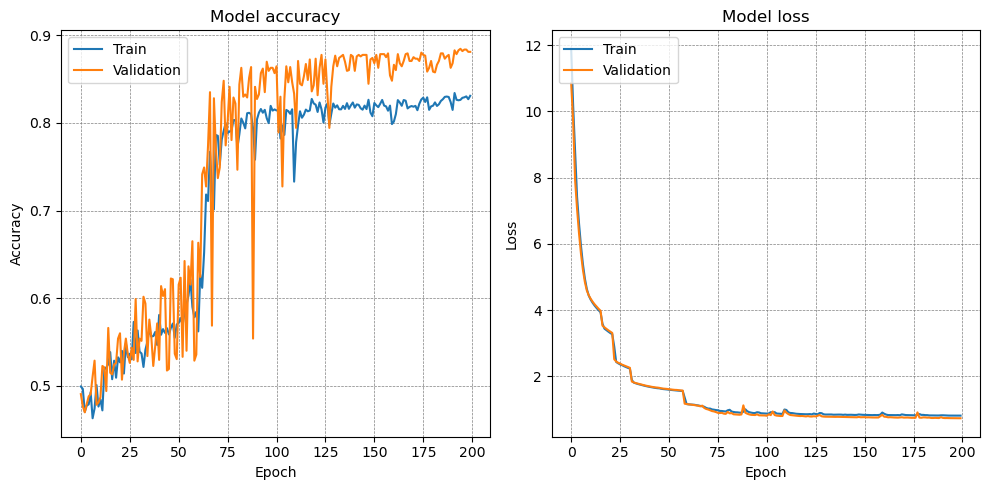

3/3 [==============================] - 0s 12ms/step


2024-07-08 21:11:42.896220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


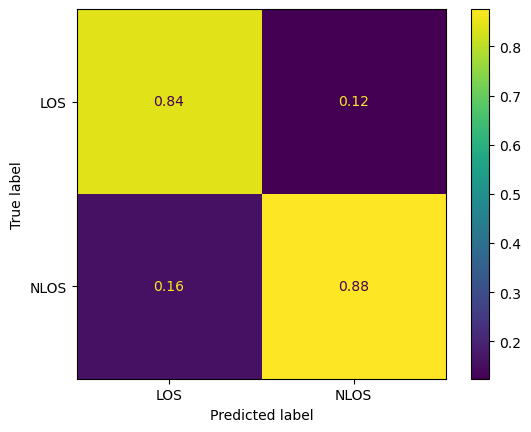

In [15]:
integ = Integrator(XX_meta, YY_meta, bs_counts=18)
integ.UnderSampling().train_test_split()
#integ.build_model()
integ.compile(optimizer='adam', loss='binary_crossentropy', metrics = None)
integ.model_summary()

integ.fit(epochs=200, batch_size=32, verbose=0, callbacks=None, validation_split = 0.1)
integ.plot_history()

integ.predict()
integ.confusion_matrix()